# Preamble

## import

In [14]:
import os

import numpy as np

import nengo
from nengo.params import Default, NumberParam
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.neurons import *
from nengo.builder.neurons import *

from nengolib.signal import s, nrmse, LinearSystem
from nengolib.synapses import Lowpass

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

## utilities

In [15]:
def norms(signal, freq, amp, ss, tau, t, dt=0.001, plot=False):
    lpf=nengo.Lowpass(tau)
    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: amp*np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(period=t/2, high=freq, rms=amp, seed=ss))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False, dt=dt) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral], dt=dt)
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    if plot:
        plt.plot(sim.trange(), stimulus, label='stim', alpha=0.5)
        plt.plot(sim.trange(), target, label='integral', alpha=0.5)
        plt.plot(sim.trange(), lpf.filt(sim.data[p_integral]/norm_f, dt=dt), label='target', alpha=0.5)
        plt.legend()
        plt.show()
    return norm, norm_s, norm_f

In [16]:
def bin_activities_values_1d(
    xhat_pre,
    act_bio,
    x_min=-1,
    x_max=1,
    n_neurons=10,
    n_eval_points=20):

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    x_bins = np.linspace(x_min, x_max, num=n_eval_points)
    hz_means = np.empty((n_neurons, n_eval_points))
    hz_stds = np.empty((n_neurons, n_eval_points))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x])
            hz_stds[i, x] = np.std(bin_act[x])

    return x_bins, hz_means, hz_stds

In [17]:
def hyperopt_objective(hyps):
    num = 1  # constant term?
    den = 1  # constant term?
    for n in range(hyps['n_num']): # terms in transfer function's numerator
        num += s**(n+1) * hyps['%s_num'%n]
    for d in range(hyps['n_den']): # terms in transfer function's denominator
        den += s**(d+1) * hyps['%s_den'%d]  
    h = num / den
    h /= h.dcgain

    lpf = nengo.Lowpass(hyps['tau'])
    spk = np.load(hyps['savefile'])['spikes']
    tar = np.load(hyps['savefile'])['target']
    A = h.filt(spk, dt=hyps['dt'])[::int(hyps['dt_sample']/hyps['dt'])]
    target = lpf.filt(tar, dt=hyps['dt'])[::int(hyps['dt_sample']/hyps['dt'])]
    d = np.load(hyps['savefile'])['decoders']
    xhat = np.dot(A, d)
    if np.sum(target) != 0:
        loss = nrmse(xhat, target=target)
    else:
        loss = 0.0

    return {'loss': loss, 'h': h, 'status': STATUS_OK }

# Wilson Neuron

In [63]:
import os

import numpy as np

import nengo
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *

__all__ = ['WilsonNeuron']


class WilsonNeuron(NeuronType):
    """
    Wilson Neuron Model.
    
    Description
    -----------
    
    TODO
    
    Paramters
    ---------

    TODO
    
    References
    ----------
    [1] Wilson, Hugh R. "Simplified dynamics of human and mammalian neocortical neurons."
        Journal of theoretical biology 200.4 (1999): 375-388.

    
    """
    
    probeable = ('spikes', 'voltage', 'recovery', 'conductance', 'AP')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonNeuron, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
    @property
    def _argreprs(self):
        args = []
        def add(attr, default):
            if getattr(self, attr) != default:
                args.append("%s=%s" %(attr, getattr(self, attr)))
        add("threshold", -0.20)
        add("tau_V", 0.00097)
        add("tau_R", 0.0056)
        add("tau_H", 0.0990)
        return args
    
    def current(self, x, gain, bias):
        """Compute current injected in each neuron given input, gain and bias.

        Parameters
        ----------
        x : (n_neurons,) array_like
            Vector-space input.
        gain : (n_neurons,) array_like
            Gains associated with each neuron.
        bias : (n_neurons,) array_like
            Bias current associated with each neuron.
        """
        x = np.array(x, dtype=float, copy=False, ndmin=1)
        gain = np.array(gain, dtype=float, copy=False, ndmin=1)
        bias = np.array(bias, dtype=float, copy=False, ndmin=1)
        return gain * x + bias


    def gain_bias(self, max_rates, intercepts):
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)

        J_steps = 201  # Odd number so that 0 is a sample
        max_rate = max_rates.max()

        # Find range of J that will achieve max rates (assume monotonic)
        J_threshold = None
        J_max = None
        Jr = 1.0
        for _ in range(10):
            J = np.linspace(-Jr, Jr, J_steps)
            rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
#             print('rate', rate)
            if J_threshold is None and (rate <= 0).any():
                J_threshold = J[np.where(rate <= 0)[0][-1]]
            if J_max is None and (rate >= max_rate).any():
                J_max = J[np.where(rate >= max_rate)[0][0]]
            if J_threshold is not None and J_max is not None:
                break
            else:
                Jr *= 2
        else:
            if J_threshold is None:
                raise RuntimeError("Could not find firing threshold")
            if J_max is None:
                raise RuntimeError("Could not find max current")

        J = np.linspace(J_threshold, J_max, J_steps)
        rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))

        gain = np.zeros_like(max_rates)
        bias = np.zeros_like(max_rates)
        J_tops = np.interp(max_rates, rate, J)
        gain[:] = (J_threshold - J_tops) / (intercepts - 1)
        bias[:] = J_tops - gain
#         print('J', J)
#         print('gain', gain)
#         print('bias', bias)
        return gain, bias


    def rates(self, x, gain, bias):
        J = self.current(x, gain, bias)
        dt = 0.00005
        t_transient = 0.1
        t = 1.0
        t_range = np.arange(dt, t, dt)
        spiked = np.zeros(x.shape[0], dtype=float)
        AP = np.zeros(x.shape[0], dtype=bool)
        voltage = np.array(-0.754*np.ones(x.shape[0]))
        recovery = np.array(0.279*np.ones(x.shape[0]))
        conductance = np.array(0.0*np.ones(x.shape[0]))
        all_spikes = np.zeros((t_range.shape[0], x.shape[0]))
        for t in range(t_range.shape[0]):
            spiked, voltage, recovery, conductance, AP = self.step_math(
                dt, J, spiked, voltage, recovery, conductance, AP)
            all_spikes[t] = spiked
        
        rates = np.sum(np.array(all_spikes)[int(t_transient/dt):], axis=0) / t  # total spikes / total time
        return rates


    def step_math(self, dt, J, spiked, voltage, recovery, conductance, AP):
        dV = -(17.81 + 47.58*voltage + 33.80*np.square(voltage))*(voltage - 0.48) - 26*recovery*(voltage + 0.95) - 13*conductance*(voltage + 0.95) + J
        dR = -recovery + 1.29*voltage + 0.79 + 3.30*np.square(voltage + 0.38)
        dH = -conductance + 11*(voltage + 0.754)*(voltage + 0.69)
        
        voltage[:] = (voltage + dV * dt/self.tau_V).clip(-0.9, 0.3)
        recovery[:] = (recovery + dR * dt/self.tau_R)  # .clip(0.18, 0.42)
        conductance[:] = (conductance + dH * dt/self.tau_H)  # .clip(0, 0.23)
        spiked[:] = (voltage > self.threshold) & (~AP)
        spiked /= dt
        AP[:] = voltage > self.threshold
        
        return spiked, voltage, recovery, conductance, AP


@Builder.register(WilsonNeuron)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        -0.754*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        0.279*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        0.0*np.ones(neurons.size_in), name="%s.conductance" % neurons)
    model.sig[neurons]['AP'] = Signal(
        np.zeros(neurons.size_in, dtype=bool), name="%s.AP" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
            model.sig[neurons]['recovery'],
            model.sig[neurons]['conductance'],
            model.sig[neurons]['AP']]))

# Network

In [57]:
def simulate(  
    d_pre,
    d_supv,
    d_fb,
    h,
    t=1,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    signal='cos',
    freq=1,
    amp=1,
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=nengo.LIF(),
    gain=Default,
    bias=Default,
    max_rates=Default,
    intercepts=Default,
    **kwargs):
    
    # transform input signal u so that the integral x is normalized to np.max(x)==1
    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t, dt=dt, plot=False)
    
    # Simulate the full network, skipping simulation of supv or bio when possible.
    with nengo.Network(seed=seeds['ns']) as model:

        # Nodes
        model.T = t
        def flip(t, x):
            if t<model.T/2: return x
            elif t>=model.T/2: return -1.0*x
        if signal == 'cos':
            u_raw = nengo.Node(output=lambda t: amp*np.cos(freq*t))
        elif signal == 'white_noise':
            u_raw = nengo.Node(nengo.processes.WhiteSignal(period=model.T/2, high=freq, rms=amp, seed=seeds['ss']))
        u = nengo.Node(output=flip, size_in=1)
                                              
        # Ensembles
        pre_u = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, seed=seeds['es'], radius=norm_s)
        pre_x = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, seed=seeds['es'], radius=norm)
        supv = nengo.Ensemble(n_neurons, 1,
            gain=gain, bias=bias,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=neuron_type, seed=seeds['es'], label='supv')
        fb = nengo.Ensemble(n_neurons, 1,
            gain=gain, bias=bias,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=neuron_type, seed=seeds['es'], label='fb')
        lif = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, neuron_type=nengo.LIF(), seed=seeds['es'])
        lif_ideal = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, neuron_type=nengo.LIF(), seed=seeds['es'])
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())

        # normal connections
        nengo.Connection(u_raw, u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_x, synapse=1/s, seed=seeds['cs'])  # transform=1.0/norm_f, 
        nengo.Connection(u, tar, synapse=1/s, transform=1.0/norm_f)
        nengo.Connection(pre_u, lif, synapse=taus['network'], transform=taus['network']/norm_f)
        nengo.Connection(lif, lif, synapse=taus['network'])
        
        # supervised connections
        nengo.Connection(pre_u, supv, synapse=taus['network'],
            transform=taus['network']/norm_f, seed=seeds['cs'])
        nengo.Connection(pre_x, supv, synapse=taus['network'], # seed=seeds['cs'])
            solver=NoSolver(d_pre), seed=seeds['cs'])
        
        # feedback connections
        nengo.Connection(pre_u, fb, synapse=taus['network'],
            transform=taus['network']/norm_f, seed=seeds['cs'])
        nengo.Connection(fb, fb, synapse=h,
            solver=NoSolver(d_fb), seed=seeds['cs'])

        # probes (down sample to dt_sample in post-processing for spiking ensembles)
        p_target = nengo.Probe(tar, synapse=None, sample_every=dt)
        p_spk_pre = nengo.Probe(pre_x.neurons, synapse=None, sample_every=dt)
        p_spk_supv = nengo.Probe(supv.neurons, synapse=None, sample_every=dt)
        p_spk_fb = nengo.Probe(fb.neurons, synapse=None, sample_every=dt)
        p_spk_lif = nengo.Probe(lif.neurons, synapse=None, sample_every=dt)
        p_lif = nengo.Probe(lif, synapse=taus['readout'], sample_every=dt)
        

    # Run the simulation
    with nengo.Simulator(model, seed=seeds['ss'], dt=dt, progress_bar=True) as sim:
        sim.run(t, progress_bar=True)
        
    return dict(
        tar=sim.data[p_target],  # .ravel()
        spk_pre=sim.data[p_spk_pre],
        spk_supv=sim.data[p_spk_supv],
        spk_fb=sim.data[p_spk_fb],
        spk_lif=sim.data[p_spk_lif],
        x_lif=sim.data[p_lif])

## Decoder, Encoder, and Filter Learning

In [58]:
def update_d(
    target_data,
    spk_data,
    h,
    reg=1e-2,
    taus={'network': 0.1, 'readout': 0.1},
    dt=0.001,
    dt_sample=0.001,
    **kwargs):
    
    lpf = nengo.Lowpass(taus['readout'])
    target = lpf.filt(target_data, dt=dt)[::int(dt_sample/dt)]
    A = h.filt(spk_data, dt=dt)[::int(dt_sample/dt)]
    d_new = LstsqL2(reg=reg)(A, target)[0]
    
    return d_new

In [59]:
def update_h(
    d,
    target_data,
    spk_data,
    n_neurons=100,
    reg=1e-2,
    taus={'network': 0.1, 'readout': 0.1},
    dt=0.001,
    dt_sample=0.001,
    n_num=1,
    n_den=3,
    num_min=0,
    num_max=1,
    den_min=0,
    den_max=1,
    max_evals=100,
    **kwargs):
    
    savefile = "/home/pduggins/nengo_bioneurons/nengo_bioneurons/tests/data/quad/spikes_targets.npz"    
    np.savez(savefile, spikes=spk_data, target=target_data, decoders=d)
    hyps = dict(savefile=savefile, n_num=n_num, n_den=n_den,
        tau=taus['readout'], n_neurons=n_neurons, dt=dt, dt_sample=dt_sample)
    for num in range(n_num):  
        hyps['%s_num'%num] = hp.uniform('%s_num'%num, num_min, num_max)
    for den in range(n_den):
        hyps['%s_den'%den] = hp.uniform('%s_den'%den, den_min, den_max)
    trials = Trials()
    best = fmin(hyperopt_objective,
        rstate=np.random.RandomState(seed=kwargs['seeds']['ls']),
        space=hyps,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials)
    best_idx = np.array(trials.losses()).argmin()
    h_new = trials.trials[best_idx]['result']['h']
    
    return h_new

## Plotting

In [60]:
def make_plots(datadict, d_supv, d_fb, h, **kwargs):

    dt = kwargs['dt']
    dt_sample = kwargs['dt_sample']
    n_neurons = kwargs['n_neurons']
    taus = kwargs['taus']
    lpf = nengo.Lowpass(taus['readout'])
    A_pre = lpf.filt(datadict['spk_pre'], dt=dt)[::int(dt_sample/dt)]
    A_lif = lpf.filt(datadict['spk_lif'], dt=dt)[::int(dt_sample/dt)]
    A_supv = h.filt(datadict['spk_supv'], dt=dt)[::int(dt_sample/dt)]
    A_fb = h.filt(datadict['spk_fb'], dt=dt)[::int(dt_sample/dt)]
    target = lpf.filt(datadict['tar'], dt=dt)[::int(dt_sample/dt)]
    times = dt_sample * np.arange(0, len(target), 1)

    xhat_lif = datadict['x_lif'][::int(dt_sample/dt)]
    nrmse_lif = nrmse(xhat_lif, target=target)
    xhat_supv = np.dot(A_supv, d_supv)
    nrmse_supv = nrmse(xhat_supv, target=target)
    xhat_fb = np.dot(A_fb, d_fb)
    nrmse_fb = nrmse(xhat_fb, target=target)
    
    x_bins_pre, hz_means_pre, hz_stds_pre = bin_activities_values_1d(
        target, A_pre, n_neurons=n_neurons)
    
#     x_bins_lif, hz_means_lif, hz_stds_lif = bin_activities_values_1d(
#         xhat_lif, A_lif, n_neurons=n_neurons)
#     x_bins_supv, hz_means_supv, hz_stds_supv = bin_activities_values_1d(
#         xhat_supv, A_supv, n_neurons=n_neurons)
#     x_bins_fb, hz_means_fb, hz_stds_fb = bin_activities_values_1d(
#         xhat_fb, A_fb, n_neurons=n_neurons)
    
    x_bins_lif, hz_means_lif, hz_stds_lif = bin_activities_values_1d(
        target, A_lif, n_neurons=n_neurons)
    x_bins_supv, hz_means_supv, hz_stds_supv = bin_activities_values_1d(
        target, A_supv, n_neurons=n_neurons)
    x_bins_fb, hz_means_fb, hz_stds_fb = bin_activities_values_1d(
        target, A_fb, n_neurons=n_neurons)
 
    cmap = sns.color_palette('hls', 10)

#     a_bins, hz_means, hz_stds = bin_activities_errors_1d(A_lif, A_fb)
#     cmap = sns.color_palette('hls', 3)
#     fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
#     for n in range(3):  # n_neurons
#         ax1.plot(a_bins, hz_means[n], c=cmap[n])
#         ax1.fill_between(a_bins,
#             hz_means[n]+hz_stds[n],
#             hz_means[n]-hz_stds[n],
#             alpha=0.5, facecolor=cmap[n])
#     ax1.set(xlim=((0, np.max(A_fb[:, :3]))), xlabel='A_fb', ylabel='A_target - A_fb')
#     plt.tight_layout()
#     plt.show()    
    
#     a_error = A_lif[:, :3] - A_fb[:, :3]
#     cmap = sns.color_palette('hls', 3)
#     fig, ax = plt.subplots(1, 1, figsize=(8, 4))
#     for n in range(3):
#         ax.scatter(A_fb[:, n], a_error[:, n], s=1, c=cmap[n])
#     ax.set(xlabel='activity (fb)', ylabel='activity error')
#     plt.show()

    impulse_time = np.arange(0, 1, 0.001)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(impulse_time, Lowpass(taus['readout']).impulse(len(impulse_time)), label='lowpass')
    ax.plot(impulse_time, h.impulse(len(impulse_time)), label='optimized')
    ax.set(xlabel='time (s)', ylabel='amplitude')
    ax.legend()
    plt.tight_layout()
    plt.show()

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 16), sharex=True)
#     times_spk = dt_sample * np.arange(0, len(datadict['spk_supv']), 1)
#     rasterplot(times_spk, datadict['spk_supv'], ax=ax1)
#     rasterplot(times_spk, datadict['spk_fb'], ax=ax2)
#     ax1.set(xlabel='time', ylabel='neuron', title='supv')
#     ax2.set(xlabel='time', title='fb')
#     plt.tight_layout()

    a_error_supv = np.average(np.abs(A_supv - A_lif))
    a_error_fb = np.average(np.abs(A_fb - A_lif))
#     a_error_fb = np.average(np.abs(A_fb - A_supv))
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
    for n in range(10):  # n_neurons
        ax1.plot(x_bins_pre, hz_means_pre[n], c=cmap[n])
        ax1.fill_between(x_bins_pre,
            hz_means_pre[n]+hz_stds_pre[n],
            hz_means_pre[n]-hz_stds_pre[n],
            alpha=0.5, facecolor=cmap[n])
        ax2.plot(x_bins_lif, hz_means_lif[n], c=cmap[n])
        ax2.fill_between(x_bins_lif,
            hz_means_lif[n]+hz_stds_lif[n],
            hz_means_lif[n]-hz_stds_lif[n],
            alpha=0.5, facecolor=cmap[n])
        ax3.plot(x_bins_supv, hz_means_supv[n], c=cmap[n])
        ax3.fill_between(x_bins_supv,
            hz_means_supv[n]+hz_stds_supv[n],
            hz_means_supv[n]-hz_stds_supv[n],
            alpha=0.5, facecolor=cmap[n])
        ax4.plot(x_bins_fb, hz_means_fb[n], c=cmap[n])
        ax4.fill_between(x_bins_fb,
            hz_means_fb[n]+hz_stds_fb[n],
            hz_means_fb[n]-hz_stds_fb[n],
            alpha=0.5, facecolor=cmap[n])
    ax1.set(xlim=((-1,1)), xlabel='$\mathbf{x}$', ylabel='activity (Hz)', title='pre_x')
    ax2.set(xlim=((-1,1)), xlabel='$\mathbf{x}$', title='lif')
    ax3.set(xlim=((-1,1)), xlabel='$\mathbf{x}$', title='supv \n rmse=%.3f' %a_error_supv)
    ax4.set(xlim=((-1,1)), xlabel='$\mathbf{x}$', title='fb \n rmse=%.3f' %a_error_fb)
    plt.tight_layout()

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(times, target, label='target', linestyle='--')
    ax.plot(times, xhat_lif, alpha=0.5, label='lif, nrmse=%.3f' %nrmse_lif)
    ax.plot(times, xhat_supv, alpha=0.5, label='supv, nrmse=%.3f' %nrmse_supv)
    ax.plot(times, xhat_fb, alpha=0.5, label='fb, nrmse=%.3f' %nrmse_fb)
    ax.set(xlabel='time', ylabel='$\mathbf{x}$')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

## Control Structure

In [61]:
def run(optimize_h=False, **kwargs):
    
    rng = np.random.RandomState(seed=kwargs['seeds']['ls'])
    d_pre = np.zeros((kwargs['n_neurons'], 1))
    d_supv = np.zeros((kwargs['n_neurons'], 1))
    d_fb = np.zeros((kwargs['n_neurons'], 1))
    h = Lowpass(kwargs['taus']['readout'])
    dt_set = kwargs['dt']
       
    print("oracle method to compute decoders for weight matrix pre_x => supv")
    kwargs['dt'] = 0.001
    datadict1 = simulate(d_pre, d_supv, d_fb, h, **kwargs)
    d_pre = update_d(datadict1['tar'], datadict1['spk_pre'], h, **kwargs)
    make_plots(datadict1, d_supv, d_fb, h, **kwargs)

    print("oracle method to compute readout decoders for supv (also d_fb)")
    kwargs['dt'] = dt_set
    datadict2 = simulate(d_pre, d_supv, d_fb, h, **kwargs)
    d_supv = update_d(datadict2['tar'], datadict2['spk_supv'], h, **kwargs)
    d_fb = d_supv
    
    if optimize_h:
        print("filter optimization for computing x_supv from spk_supv and d_supv")
        h = update_h(d_supv, datadict2['tar'], datadict2['spk_supv'], **kwargs)
    make_plots(datadict2, d_supv, d_fb, h, **kwargs)

    print("testing (no supervision)")
    kwargs['seeds']['ss'] = kwargs['seeds']['ss'] + 1
    kwargs['signal'] = 'white_noise'
    datadict3 = simulate(d_pre, d_supv, d_fb, h, **kwargs)
    make_plots(datadict3, d_supv, d_fb, h, **kwargs)
   
    return d_pre, d_supv, d_fb

# Simulations

## LIF

oracle method to compute decoders for weight matrix pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

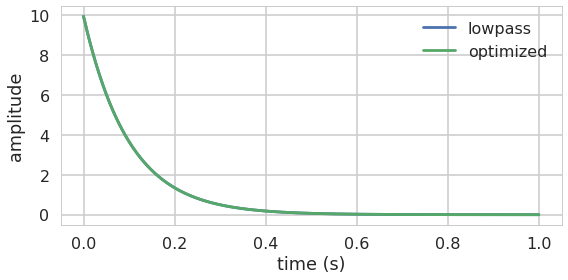

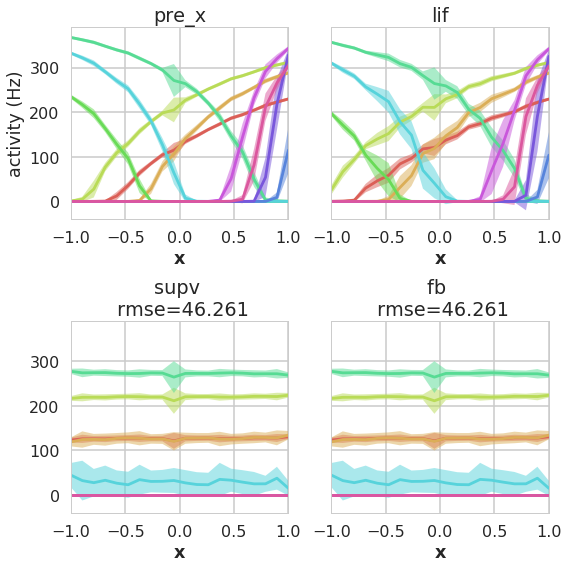

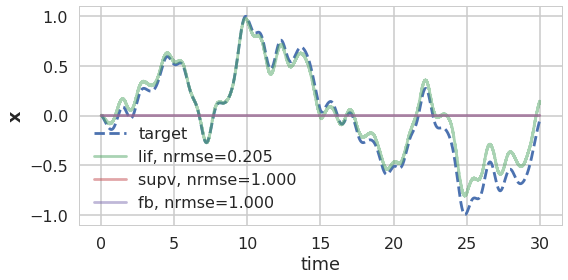

oracle method to compute readout decoders for supv (also d_fb)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

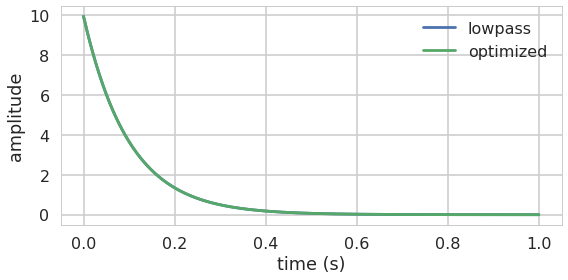

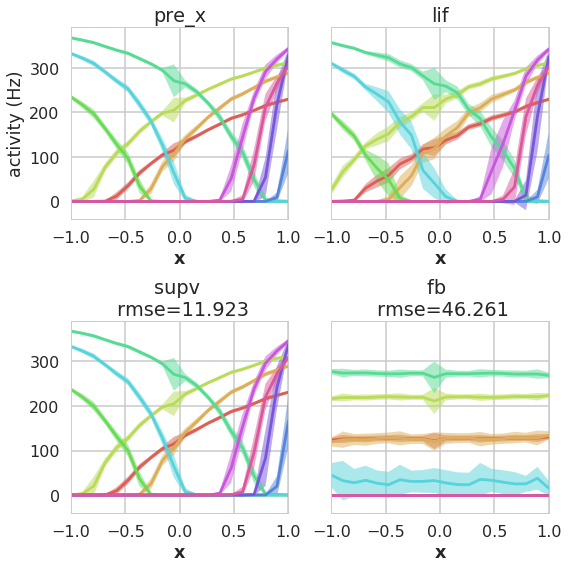

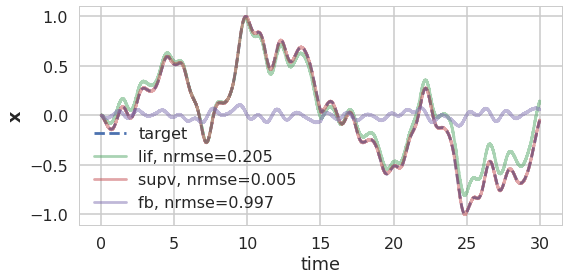

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

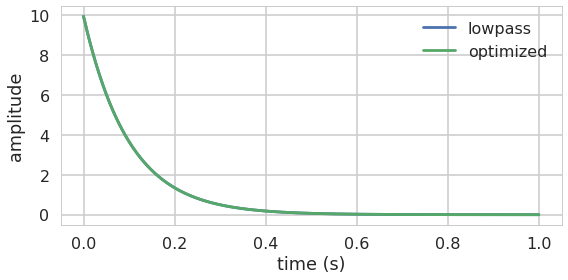

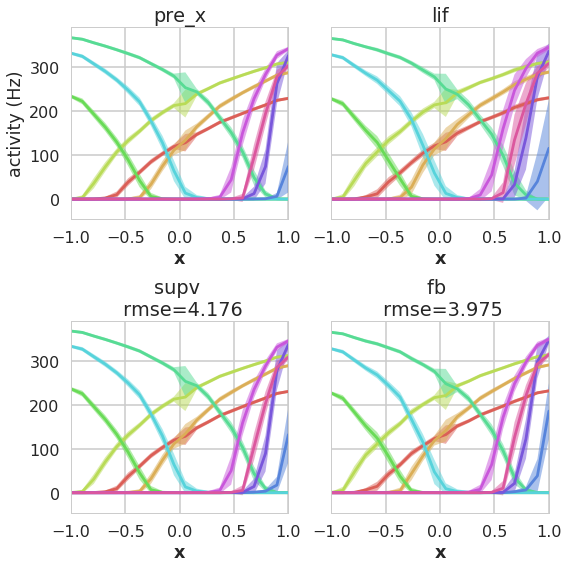

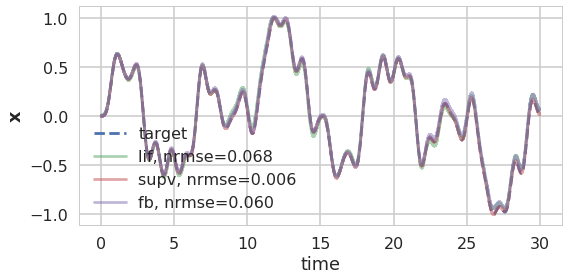

In [62]:
kwargs = dict(
    t=30,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Default,
    intercepts=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    reg=1e-2,
    n_num=1, 
    n_den=3,
    num_min=0,
    num_max=1,
    den_min=0,
    den_max=1,
    max_evals=1000,
    signal='white_noise')

d_pre, d_supv, d_fb = run(**kwargs)

## ALIF

### default

oracle method to compute decoders for weight matrix pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

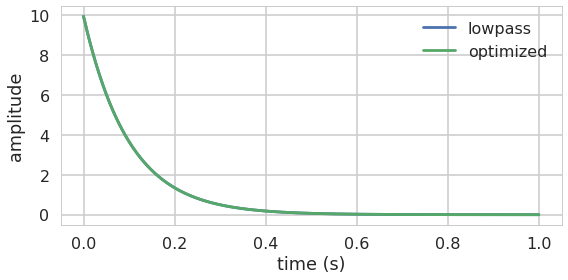

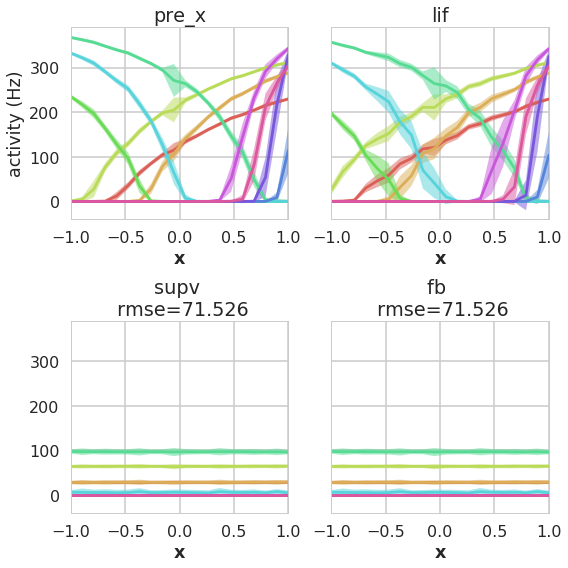

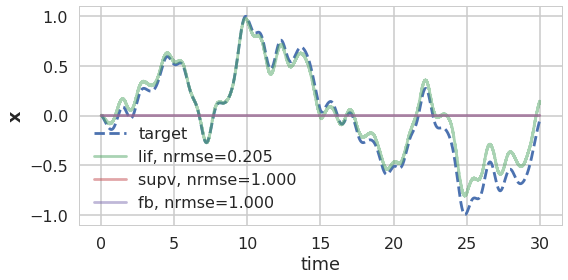

oracle method to compute readout decoders for supv (also d_fb)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

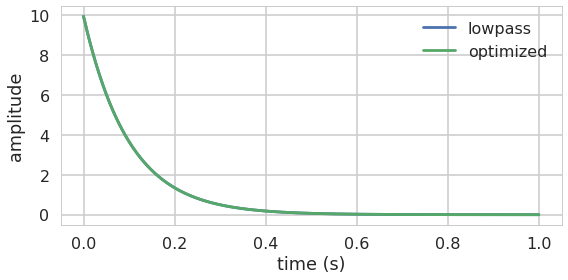

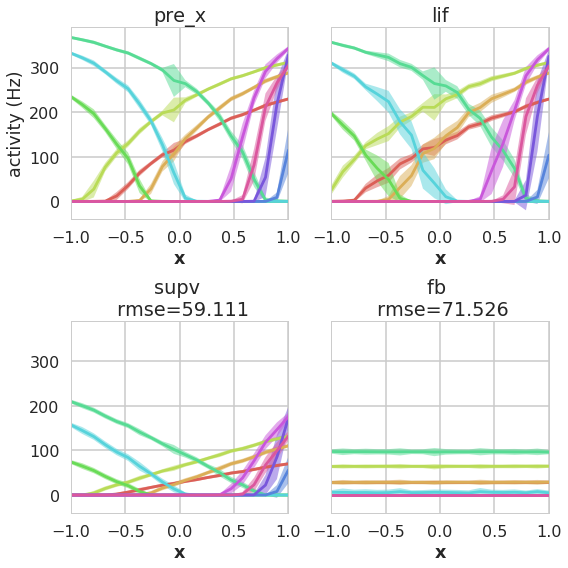

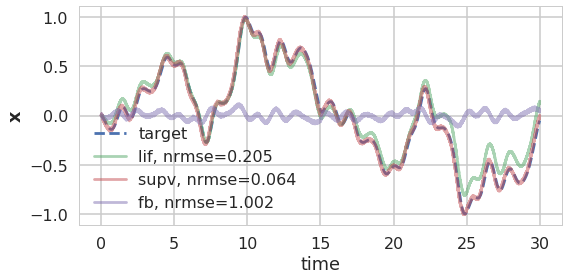

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

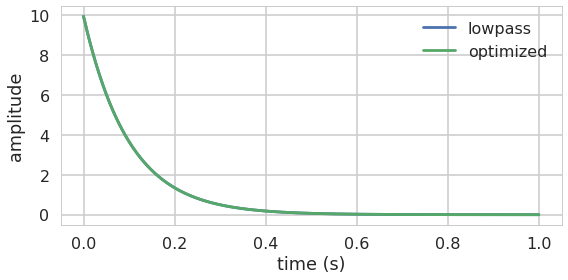

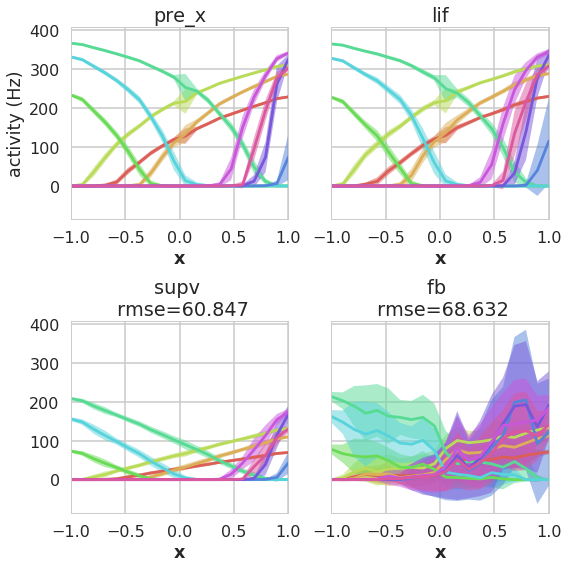

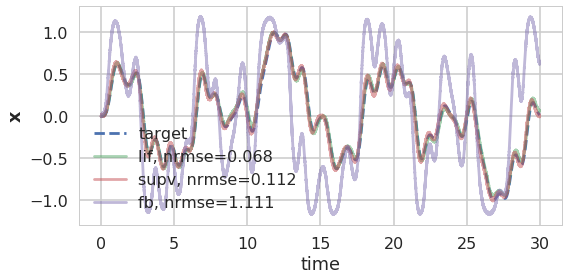

In [34]:
kwargs = dict(
    t=30,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Default,
    intercepts=Default,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    reg=1e-2,
    n_num=1, 
    n_den=3,
    num_min=0,
    num_max=1,
    den_min=0,
    den_max=1,
    max_evals=1000,
    signal='white_noise')

d_pre, d_supv, d_fb = run(**kwargs)

### filter

oracle method to compute decoders for weight matrix pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

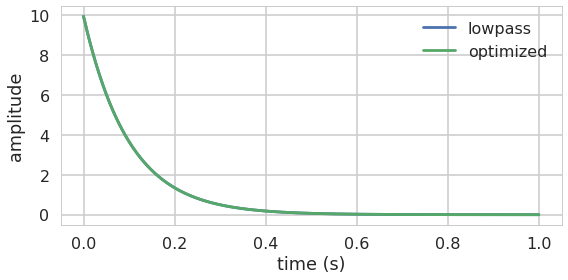

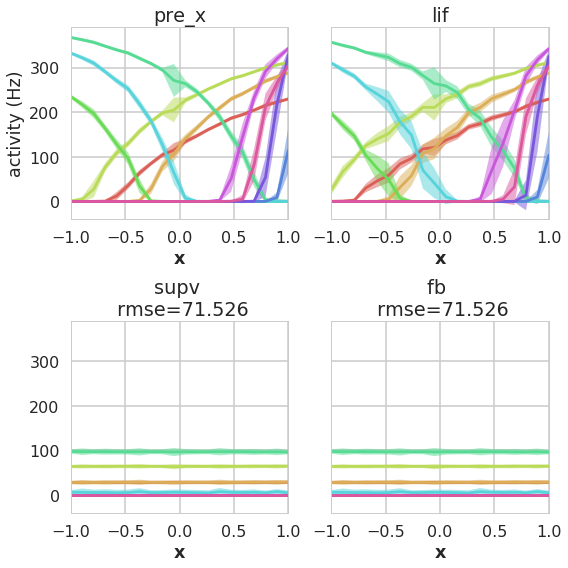

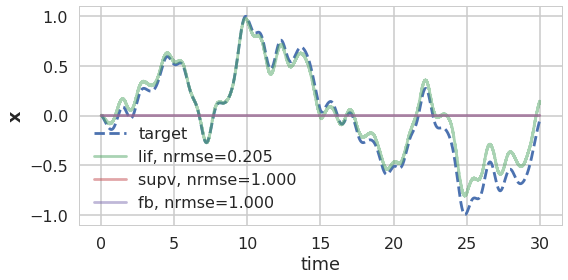

oracle method to compute readout decoders for supv (also d_fb)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

filter optimization for computing x_supv from spk_supv and d_supv


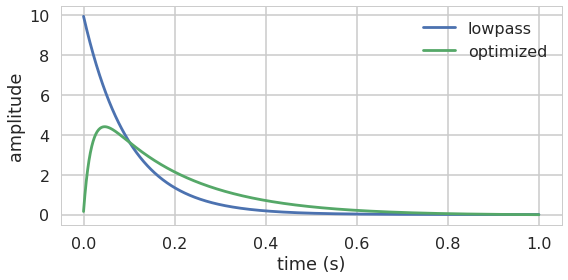

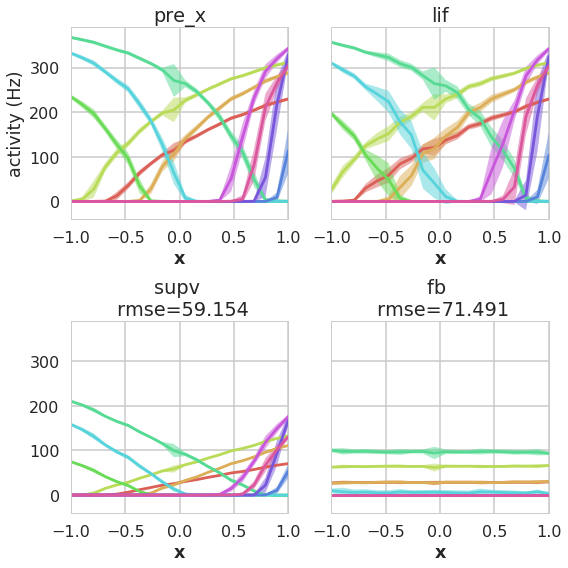

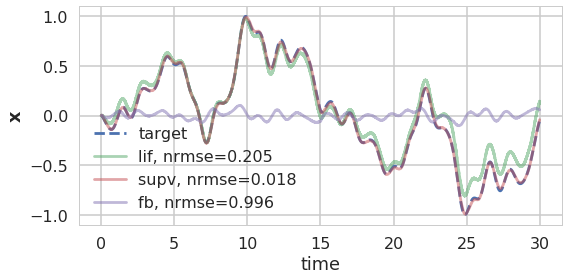

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

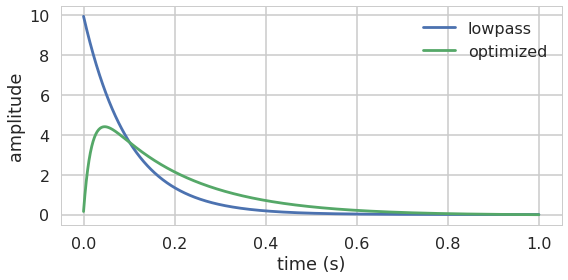

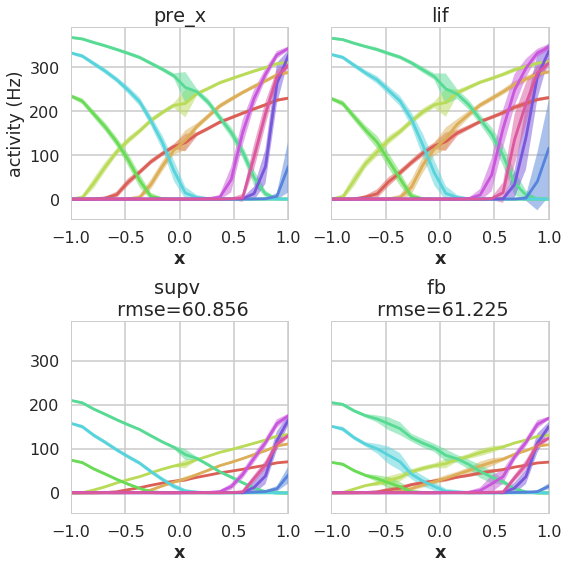

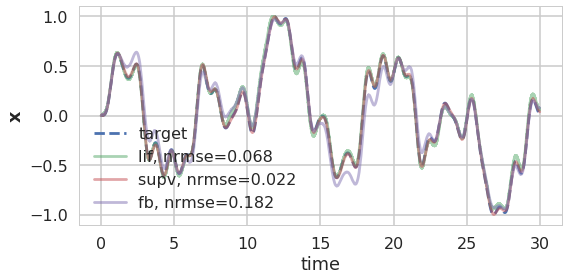

In [29]:
kwargs = dict(
    t=30,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Default,
    intercepts=Default,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    reg=1e-2,
    n_num=1, 
    n_den=3,
    num_min=0,
    num_max=1,
    den_min=0,
    den_max=1,
    max_evals=1000,
    signal='white_noise')

d_pre, d_supv, d_fb = run(optimize_h=True, **kwargs)

## Wilson Neuron

oracle method to compute decoders for weight matrix pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

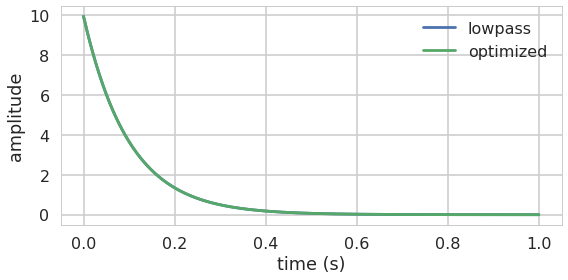

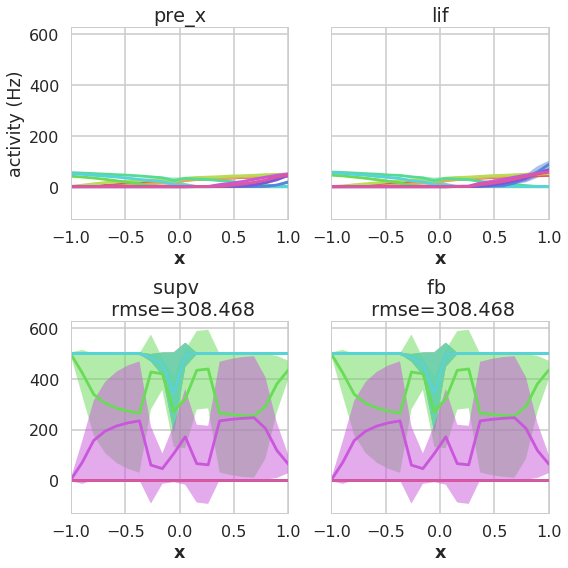

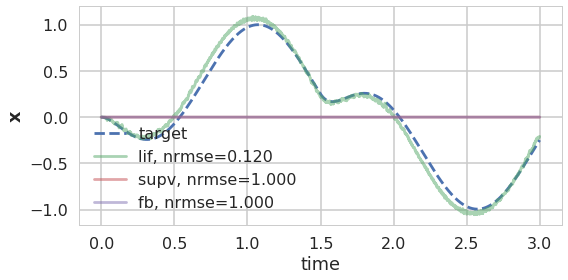

oracle method to compute readout decoders for supv (also d_fb)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

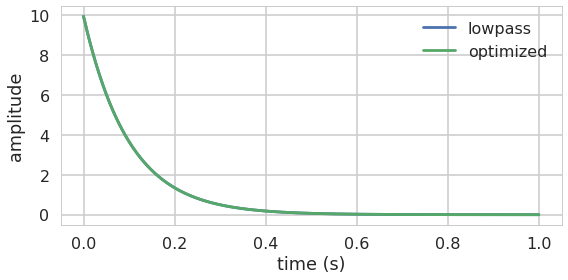

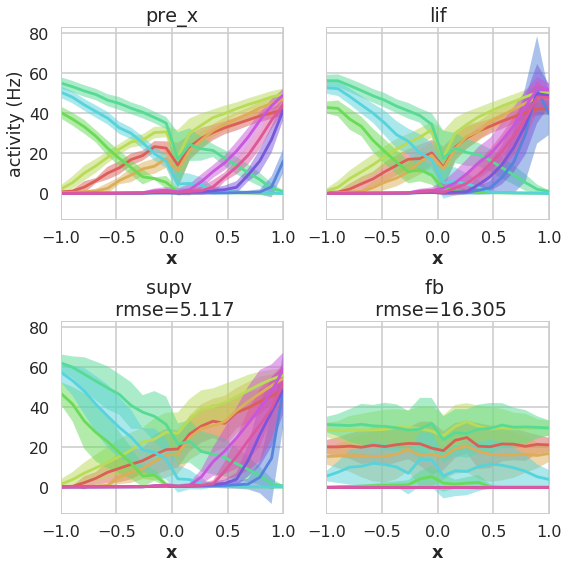

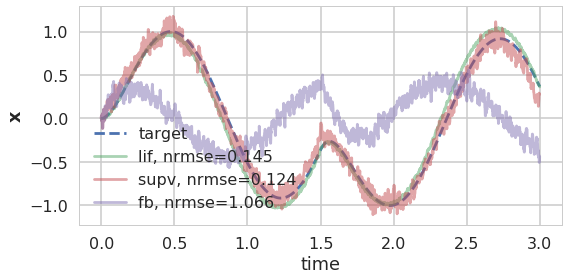

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

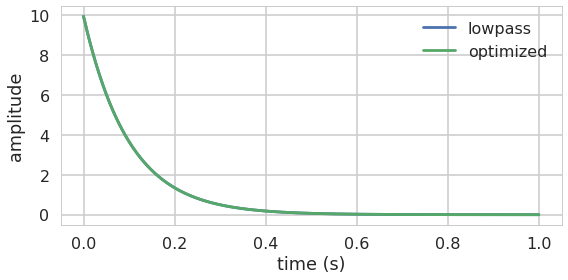

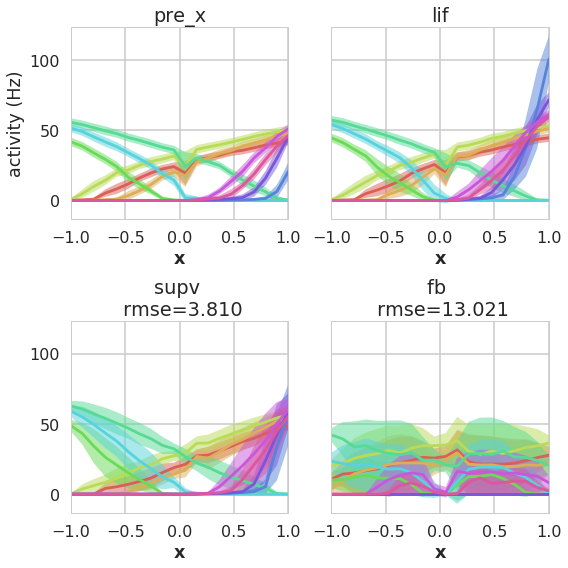

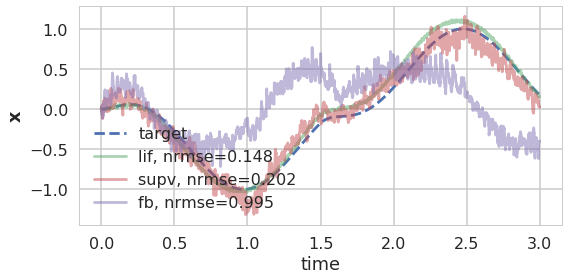

In [66]:
kwargs = dict(
    t=3,
    dt=0.00005,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Uniform(40, 60),
    intercepts=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    reg=1e-2,
    n_num=1, 
    n_den=3,
    num_min=0,
    num_max=1,
    den_min=0,
    den_max=1,
    max_evals=1000,
    signal='white_noise')

d_pre, d_supv, d_fb = run(optimize_h=False, **kwargs)

### default

oracle method to compute decoders for weight matrix pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

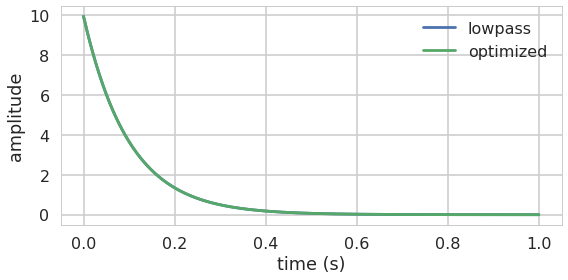

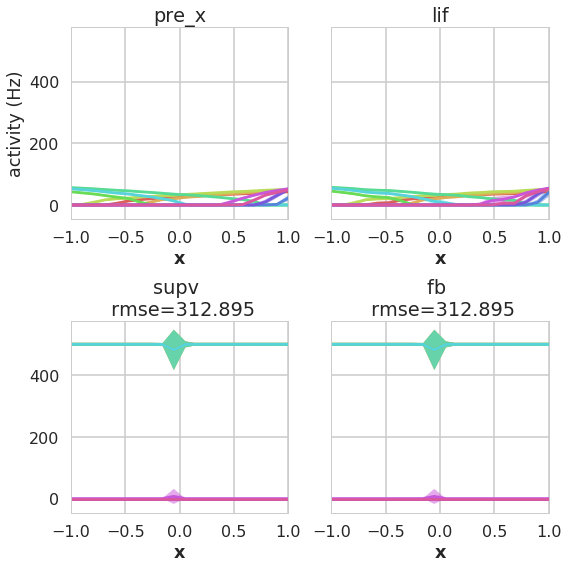

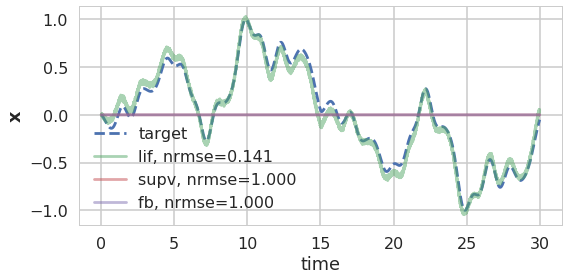

oracle method to compute readout decoders for supv (also d_fb)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

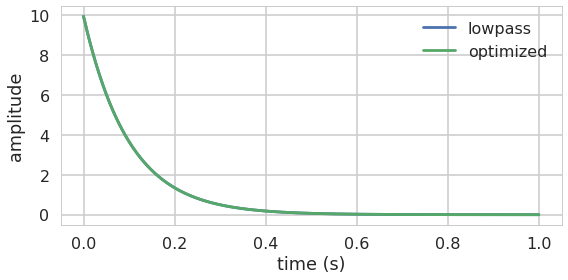

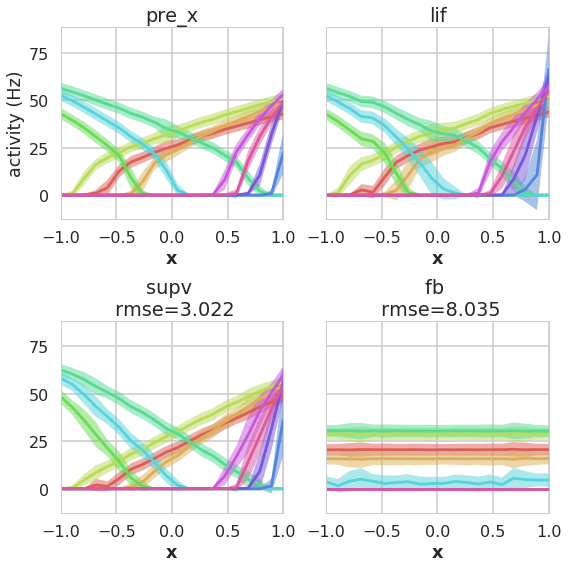

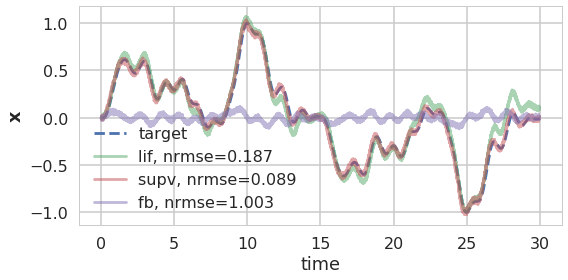

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

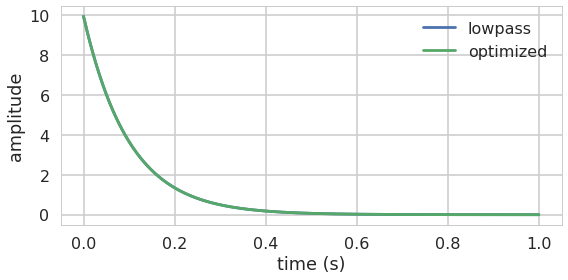

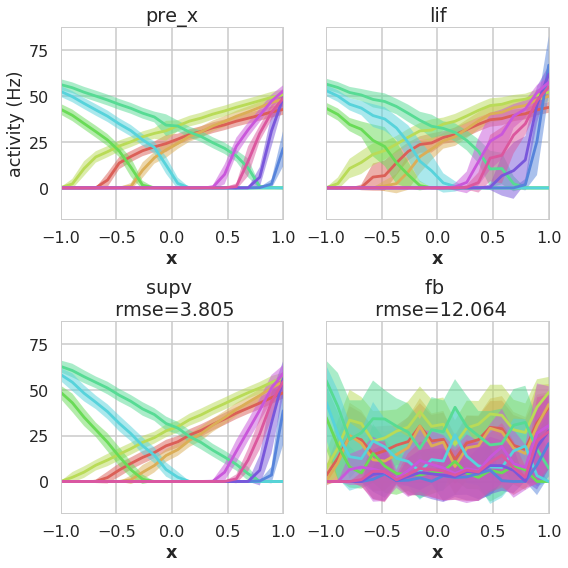

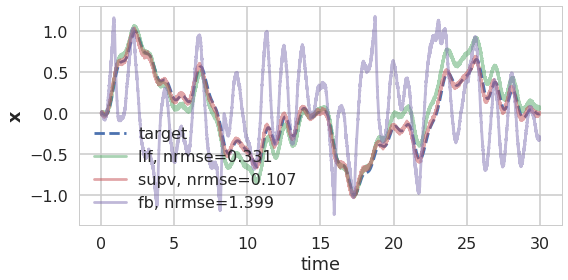

In [67]:
kwargs = dict(
    t=30,
    dt=0.00005,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Uniform(40, 60),
    intercepts=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    reg=1e-2,
    n_num=1, 
    n_den=3,
    num_min=0,
    num_max=1,
    den_min=0,
    den_max=1,
    max_evals=1000,
    signal='white_noise')

d_pre, d_supv, d_fb = run(optimize_h=False, **kwargs)

### filter

oracle method to compute decoders for weight matrix pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

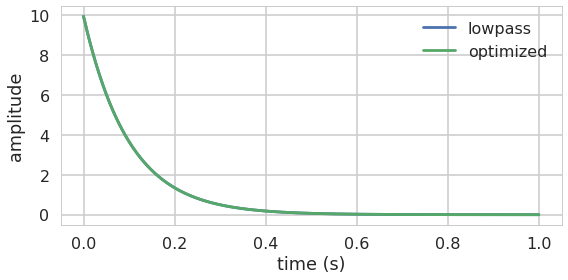

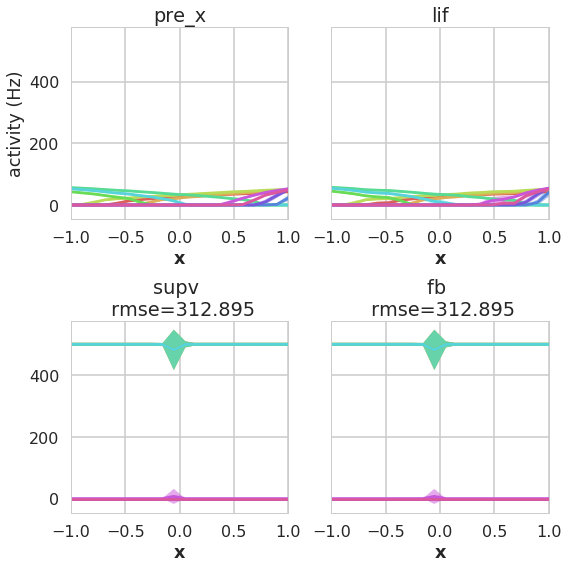

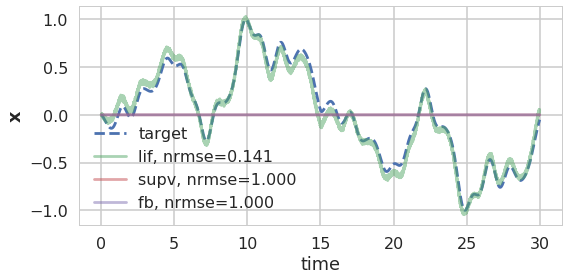

oracle method to compute readout decoders for supv (also d_fb)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

filter optimization for computing x_supv from spk_supv and d_supv


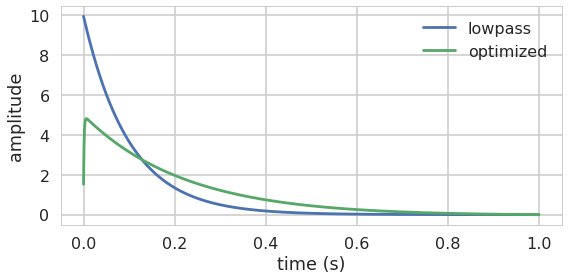

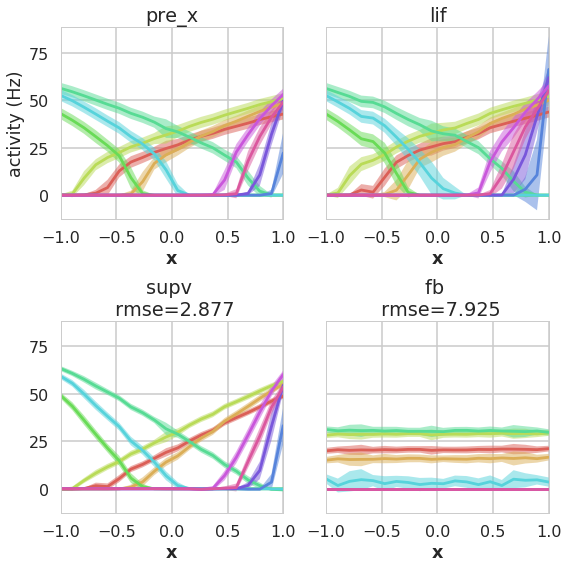

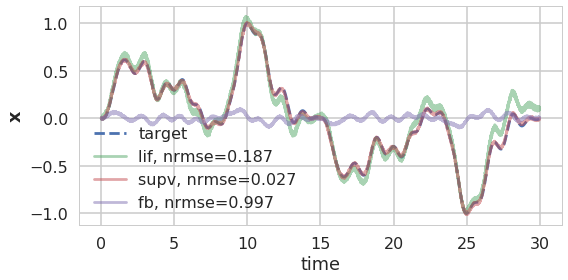

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

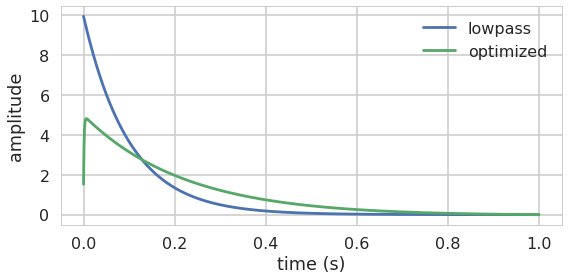

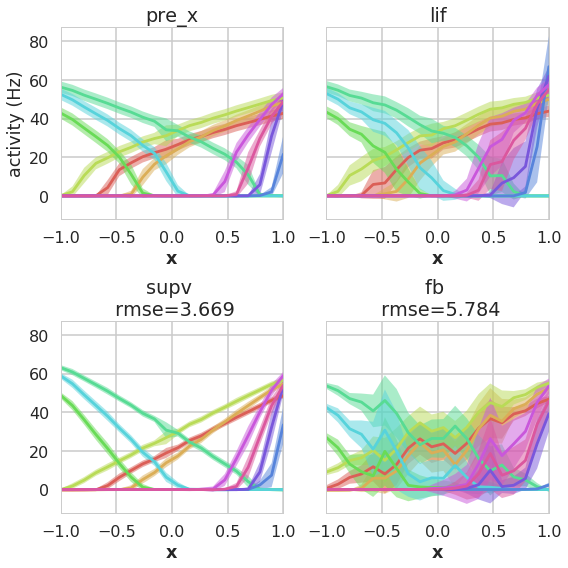

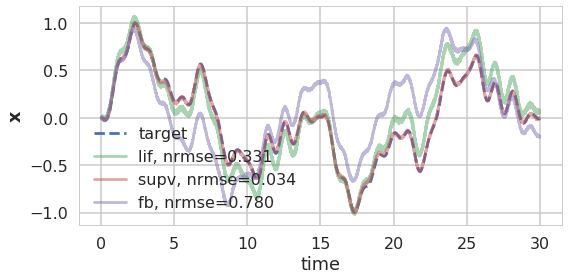

In [68]:
kwargs = dict(
    t=30,
    dt=0.00005,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Uniform(40, 60),
    intercepts=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    reg=1e-2,
    n_num=1, 
    n_den=3,
    num_min=0,
    num_max=1,
    den_min=0,
    den_max=1,
    max_evals=1000,
    signal='white_noise')

d_pre, d_supv, d_fb = run(optimize_h=True, **kwargs)

oracle method to compute decoders for weight matrix pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

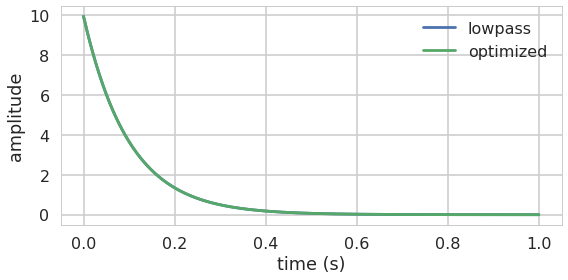

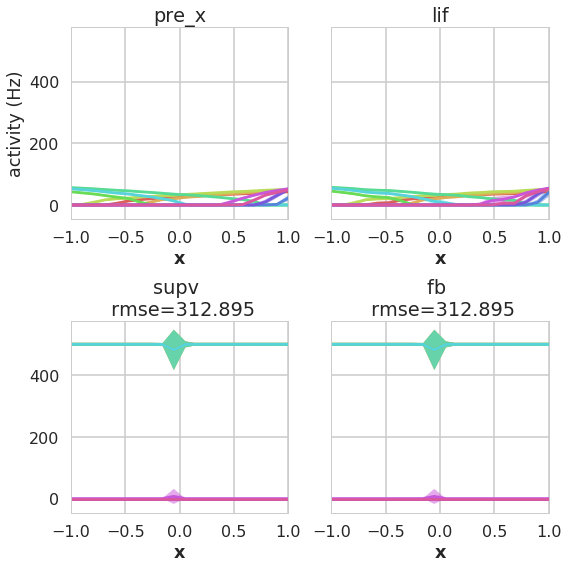

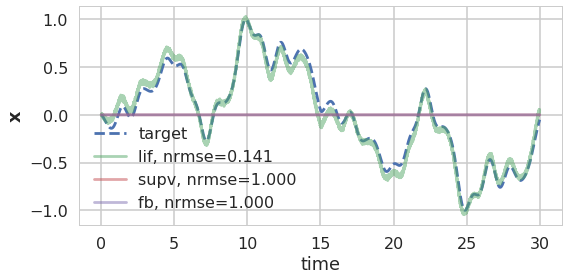

oracle method to compute readout decoders for supv (also d_fb)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

filter optimization for computing x_supv from spk_supv and d_supv


In [ ]:
kwargs = dict(
    t=30,
    dt=0.00005,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Uniform(40, 60),
    intercepts=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    reg=1e-2,
    n_num=1, 
    n_den=3,
    num_min=0,
    num_max=1,
    den_min=0,
    den_max=1,
    max_evals=10000,
    signal='white_noise')

d_pre, d_supv, d_fb = run(optimize_h=True, **kwargs)